In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

# Misc.
import warnings
warnings.filterwarnings('ignore')

#Set important constants
max_tweets = 60 # number of tweets we take from each user
max_len = 100 # max number of tokens from each tweet

In [2]:
torch.multiprocessing.set_start_method('spawn')
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#load datasets
p_df = pd.read_csv("datasets/positive_user.csv")
n_df = pd.read_csv("datasets/negative_user.csv")

#We group each dataframe by user
p_df = p_df.groupby('user')['text'].agg(list).reset_index()
n_df = n_df.groupby('user')['text'].agg(list).reset_index()[:len(p_df)] # we have more negative than positive, so we limit it here

#set labels for each
p_df["label"] = [1] * len(p_df)
n_df["label"] = [0] * len(n_df)

#bring the dataframes together
df = pd.concat([p_df, n_df])

#sets columns
df.columns = ['user','tweet','label']

tweets = []

for tweet_list in df['tweet'].values:
  if len(tweet_list) < max_tweets:
    tweet_list.extend([""] * (max_tweets - len(tweet_list))) # appends empty tweets if the user has too few
  elif len(tweet_list) > max_tweets:
    tweet_list = tweet_list[:max_tweets] # limit the size if the user has too many tweets
  tweets.append(tweet_list)

df['tweet'] = tweets #reset all the tweets to be arrays

In [4]:
class_names = ['not depressed', 'depressed']

# Set the model name
model_name = 'prajjwal1/bert-tiny'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name, force_download=True)



vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [5]:
#train test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

batch_size = 16

# row # must be multiple of batch_size
df_train = df_train[:(len(df_train) // batch_size) * batch_size]
df_val = df_val[:(len(df_val) // batch_size) * batch_size]
df_test = df_test[:(len(df_test) // batch_size) * batch_size]

In [6]:
from Dataset import TweetDataset


#creates the dataloader which is used to tokenize and order the data for training
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        reviews=df.tweet.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=8
    )

In [7]:
train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

#create dataloader for each dataframe

In [8]:
num_lstms = 6

# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name) #Bert model
        self.drop = nn.Dropout(p=0.3) # dropout layer

        self.lstm = nn.ModuleList([nn.LSTM(input_size=128, hidden_size=50, num_layers=6, batch_first=True).to(device) for _ in range(num_lstms)]) #list of LSTMS we use to process the output from each BERT
        self.batch = torch.nn.BatchNorm1d(self.lstm[0].hidden_size * num_lstms) #Batch normalization layer
        self.out = nn.Sequential(nn.Linear(self.lstm[0].hidden_size*num_lstms, 1), nn.Sigmoid()) # linear layer to map outputs to score
        

    # Forward propagation class
    def forward(self, input_ids, attention_mask):
        pooled_output = torch.zeros((batch_size, max_tweets, 128), dtype=torch.float32).to(device) # output of BERT models has to be this size, for each batch there is a vector of 128 for each tweet

        for x in range(0 , len(input_ids)): # loop through all the tweets
            _, output = self.bert(input_ids=input_ids[x], attention_mask=attention_mask[x], return_dict=False) # output from the BERT model
            output = output.to(device)
            pooled_output[:, x].copy_(output) # set its value in the array
        
        pooled_output = pooled_output.view(batch_size, num_lstms, max_tweets//num_lstms, 128) #resize in order to input into each LSTM

        lstmOut = torch.zeros((batch_size, num_lstms, self.lstm[0].hidden_size), dtype=torch.float32).to(device) #ouotput of the LSTMS will be 50 for each LSTM in a batch
        
        for i in range(len(self.lstm)): # go through each LSTM
            lstmTempOut, _ = self.lstm[i](pooled_output[:, i, :]) # get the output of the LSTM on its dataset
            lstmOut[:, i, :] = lstmTempOut[:, -1, :]# little reshaping in order to make things easy for the linear layer
        lstmOut = self.drop(lstmOut)
        lstmOut = lstmOut.view(batch_size, num_lstms*self.lstm[0].hidden_size)# flatten
        norm = self.batch(lstmOut)# batch normalizing
        
       
        return self.out(norm)# return the output from the linear layer

In [9]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [10]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [11]:
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")  # only use cuda for training

In [12]:
# Number of iterations
EPOCHS = 20

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
'''
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
'''
scheduler = OneCycleLR(optimizer, max_lr = 1e-4, total_steps = total_steps)
# Set the loss function
loss_fn = nn.BCELoss().to(device)

In [13]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, progress_bar=None):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = torch.stack(d["input_ids"]).to(device)
        attention_mask = torch.stack(d["attention_mask"]).to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        outputs = outputs.view(-1, 1).float()
        targets = targets.view(-1, 1).float()

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(outputs.round() == targets)
        losses.append(loss.item())
        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)

        if progress_bar:
            progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

In [14]:
def eval_model(model, data_loader, loss_fn, device, n_examples, progress_bar=None):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = torch.stack(d["input_ids"]).to(device)
            attention_mask = torch.stack(d["attention_mask"]).to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            outputs = outputs.view(-1, 1).float()
            targets = targets.view(-1, 1).float()

            #print("OUTPUT", outputs)
            #print("TARGET", targets)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(outputs.round() == targets)
            losses.append(loss.item())

            if progress_bar:
                progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

In [15]:
%%time


from tqdm import tqdm

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)


    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")


    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/20
----------


Training: 100%|███████████████████████████████| 248/248 [01:52<00:00,  3.53it/s]

Train loss 0.7242220056153112 accuracy 0.5063004032258064


Validation: 100%|███████████████████████████████| 31/31 [00:18<00:00,  7.79it/s]

Val   loss 0.6798900288920249 accuracy 0.6008064516129032

Epoch 2/20
----------


Training: 100%|███████████████████████████████| 248/248 [01:37<00:00,  3.62it/s]

Train loss 0.6395005259302354 accuracy 0.6255040322580645


Validation: 100%|███████████████████████████████| 31/31 [00:18<00:00,  8.37it/s]

Val   loss 0.45423666796376627 accuracy 0.8125

Epoch 3/20
----------


Training: 100%|███████████████████████████████| 248/248 [01:36<00:00,  3.53it/s]

Train loss 0.436114304668961 accuracy 0.7951108870967741


Validation: 100%|███████████████████████████████| 31/31 [00:17<00:00,  8.08it/s]

Val   loss 0.37489691617027404 accuracy 0.8185483870967741

Epoch 4/20
----------


Training: 100%|███████████████████████████████| 248/248 [01:37<00:00,  3.59it/s]

Train loss 0.3205094337463379 accuracy 0.8578629032258064


Validation: 100%|███████████████████████████████| 31/31 [00:18<00:00,  7.78it/s]

Val   loss 0.38026305071769223 accuracy 0.8407258064516129

Epoch 5/20
----------


Training: 100%|███████████████████████████████| 248/248 [02:17<00:00,  2.39it/s]

Train loss 0.22062100218458763 accuracy 0.9117943548387096


Validation: 100%|███████████████████████████████| 31/31 [00:27<00:00,  7.55it/s]

Val   loss 0.3062940327630889 accuracy 0.875

Epoch 6/20
----------


Training: 100%|███████████████████████████████| 248/248 [02:01<00:00,  3.22it/s]

Train loss 0.15366909394769238 accuracy 0.9448084677419355


Validation: 100%|███████████████████████████████| 31/31 [00:22<00:00,  6.07it/s]

Val   loss 0.3900928544181009 accuracy 0.8689516129032258

Epoch 7/20
----------


Training: 100%|███████████████████████████████| 248/248 [01:44<00:00,  3.47it/s]

Train loss 0.10198744314989346 accuracy 0.9700100806451613


Validation: 100%|███████████████████████████████| 31/31 [00:18<00:00,  7.21it/s]

Val   loss 0.5399003764914889 accuracy 0.842741935483871

Epoch 8/20
----------


Training: 100%|███████████████████████████████| 248/248 [01:41<00:00,  3.13it/s]

Train loss 0.07045689635185315 accuracy 0.9773185483870968


Validation: 100%|███████████████████████████████| 31/31 [00:18<00:00,  8.05it/s]

Val   loss 0.5409116858556386 accuracy 0.844758064516129

Epoch 9/20
----------


Training:  38%|████████████                    | 93/248 [00:46<00:49,  3.13it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3ebe9fa940>
Traceback (most recent call last):
  File "/home/jamesli/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/jamesli/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

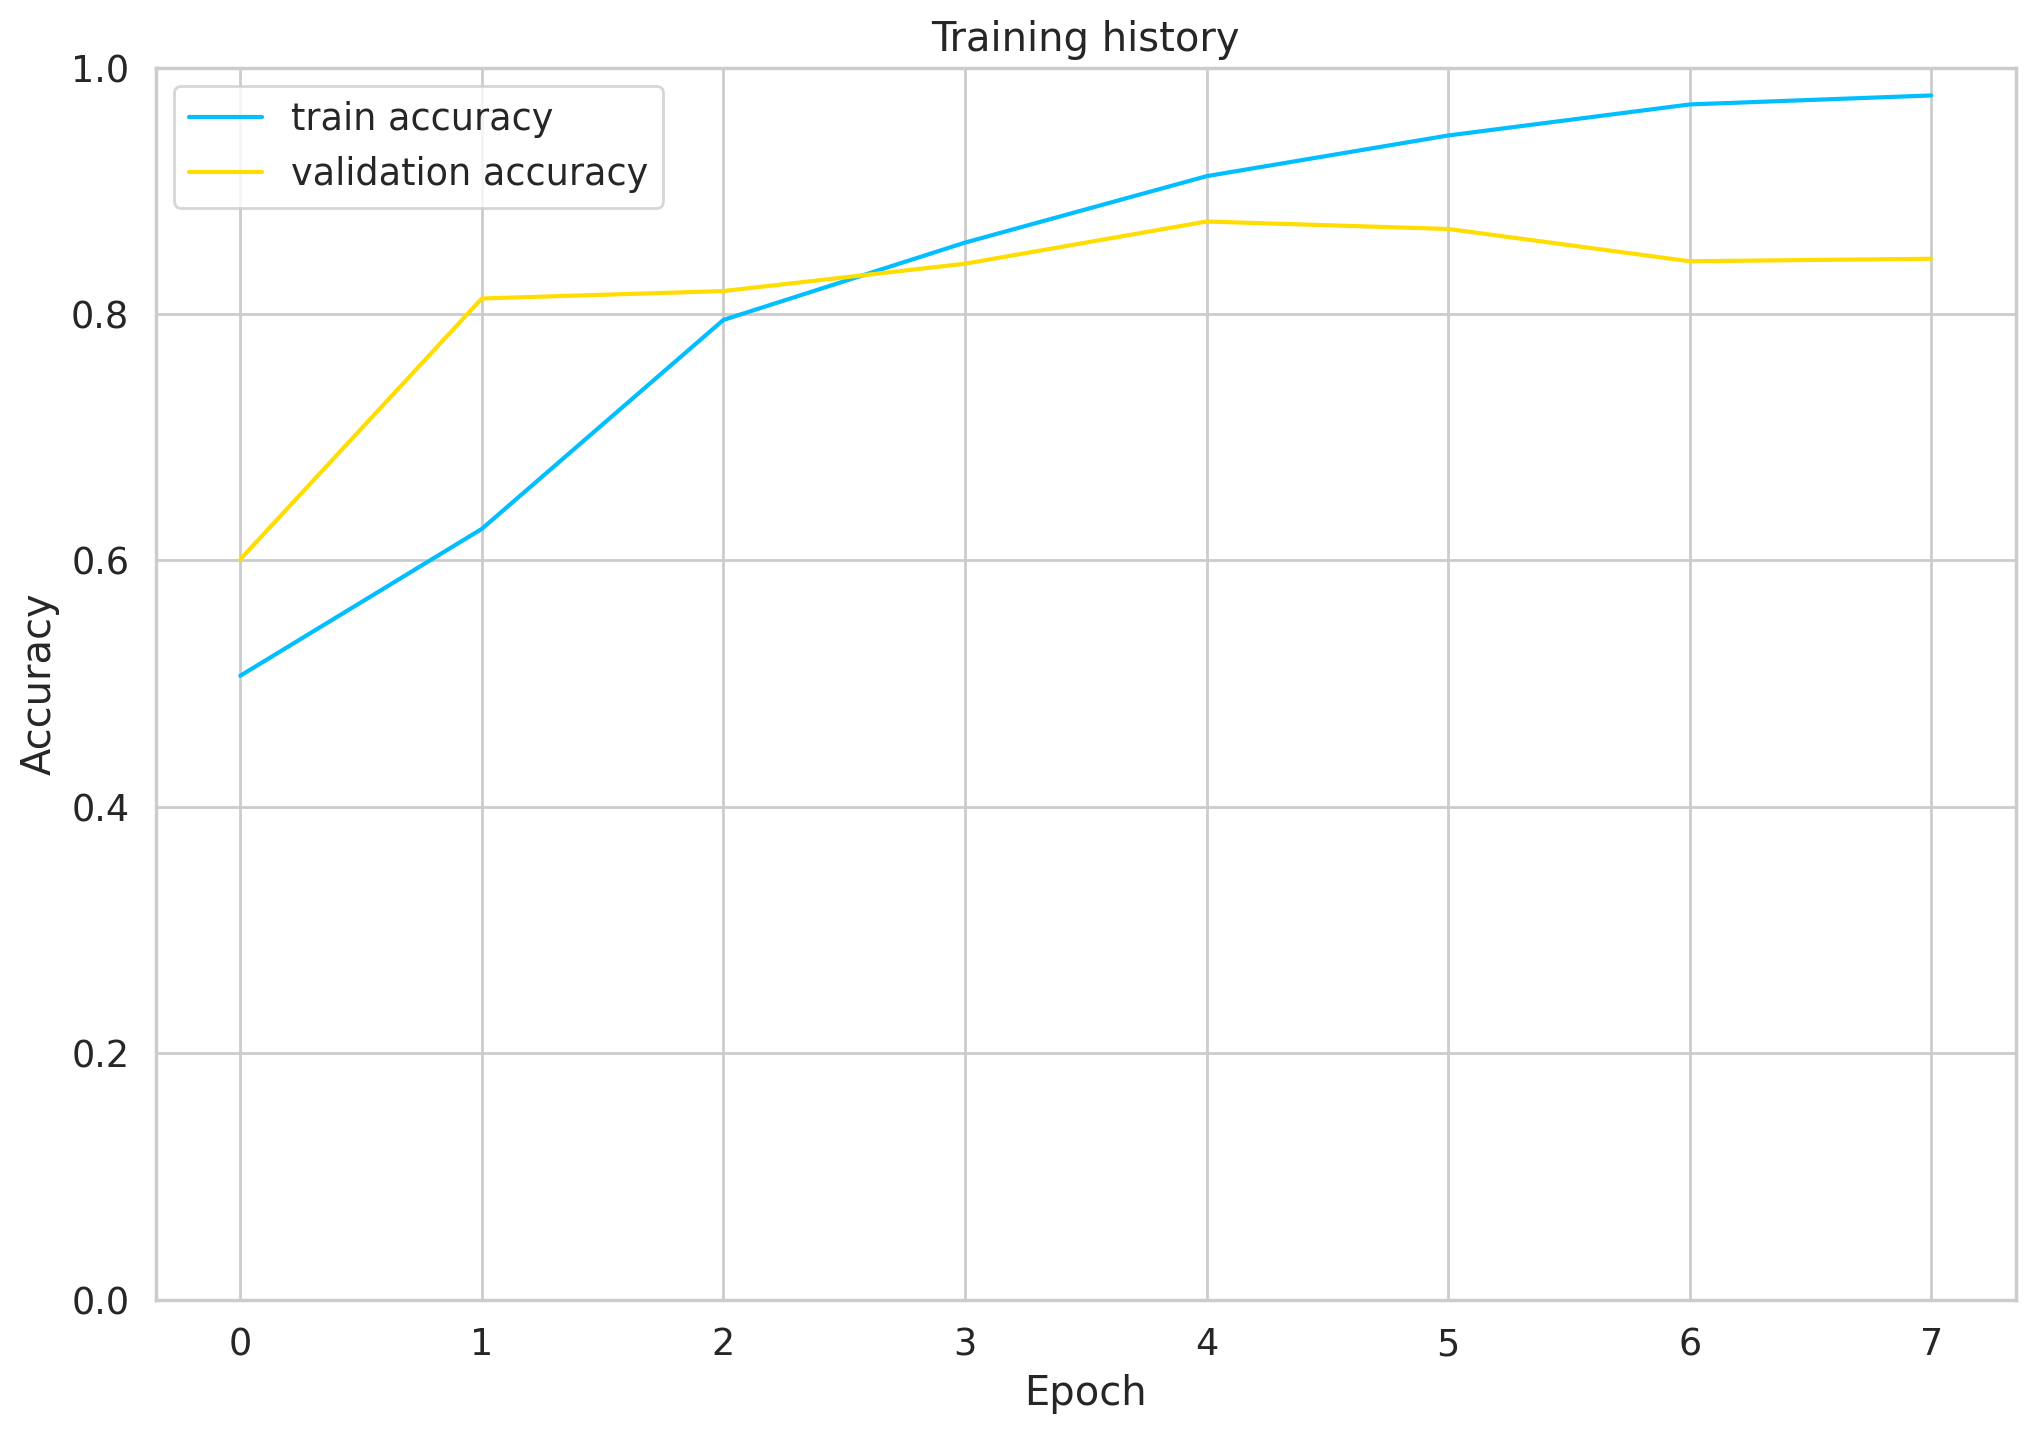

In [17]:
# Plot training and validation accuracy 
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [18]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.842741935483871

In [18]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = [x.to(device) for x in d["input_ids"]]
            attention_mask = [x.to(device) for x in d["attention_mask"]]
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            preds = torch.flatten(outputs.round())

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [19]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [20]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.84      0.85      0.85       252
    depressed       0.85      0.84      0.84       244

     accuracy                           0.84       496
    macro avg       0.84      0.84      0.84       496
 weighted avg       0.84      0.84      0.84       496



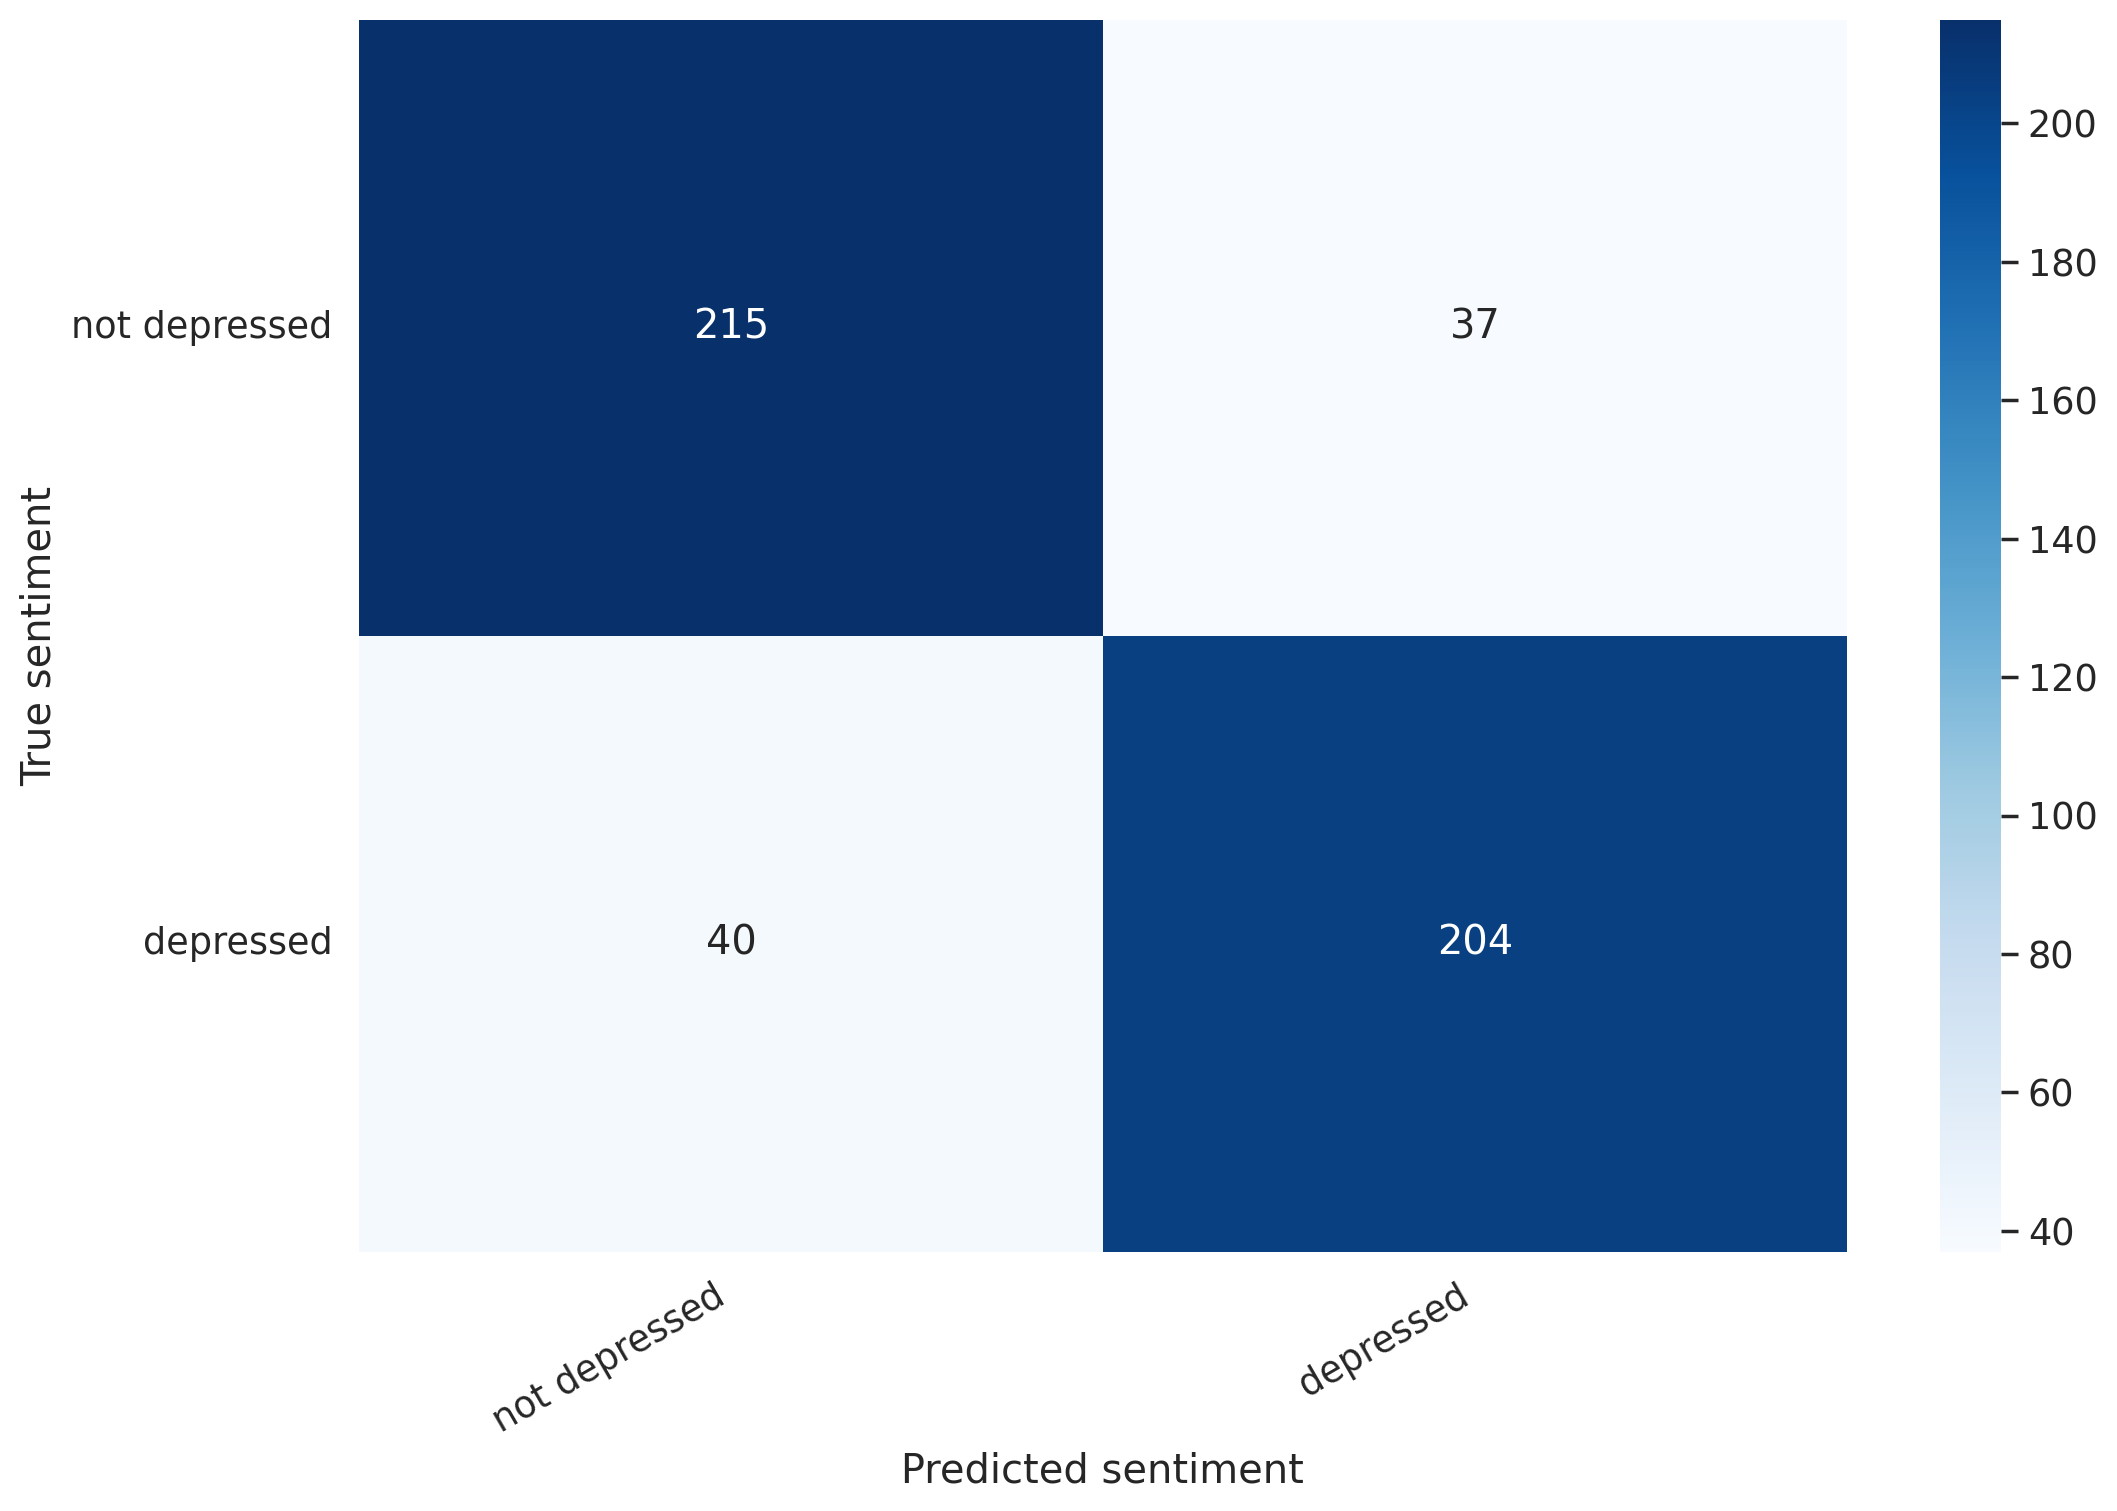

In [21]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [19]:
torch.save(model.state_dict(), "2.pt")

In [22]:
m = SentimentClassifier(2)
m.load_state_dict(torch.load("best_model_state.bin"))
m.eval()

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [23]:
test_acc, _ = eval_model(
  m,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8608870967741935

In [22]:

test = torch.load("2.pt", map_location=torch.device('cuda'))

In [23]:
m = SentimentClassifier(len(class_names))
m.load_state_dict(test)
m = m.to(device)

In [24]:
test_acc, _ = eval_model(
  m,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.5080645161290323